# Task 1

## Data preparation

Before we can start solving the tasks we need to prepare the input data. As in mini project 2, we use the answerList_data.csv file. We create a column `correctness` that specifies if the ground truth and the answer of the participant match. We also need to transform some of the columns to values, we can use in our classifier later and calculate the TTR (token-type-ratio) of each explanation. Then we split the data into a training and a holdout set and those again into student and non-student data. We balance the training data to have the same number of correct and incorrect answers. We also only use the input columns `Worker.score`, `Answer.duration`, `TTR`, `explanation_size`, `Answer.confidence`, and `Answer.difficulty` since they were given in the task.

In [1]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import precision_score, recall_score
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv('../../data/answerList_data.csv')
df['correctness'] = (((df['GroundTruth'] == 0.0) & (df['Answer.option'] == 'NO')) | (
            (df['GroundTruth'] == 1.0) & (df['Answer.option'] == 'YES'))).astype(int)

df

,Answer.ID,FailingMethod,Question.ID,Answer.duration,Answer.confidence,Answer.difficulty,GroundTruth,TP,TN,FN,...,Worker.ID,Worker.score,Worker.profession,Worker.yearsOfExperience,Worker.age,Worker.gender,Worker.whereLearnedToCode,Worker.country,Worker.programmingLanguage,correctness
0,261,HIT01_8,0,90.984,4,2,0,0,1,0,...,832cg-7G1i-462:73eI-8E-2g-985,5,Undergraduate_Student,7.0,21,Male,High School,United States,Java; C++; C#,1
1,262,HIT01_8,0,133.711,5,1,0,0,1,0,...,98ce7A-4i-507,4,Undergraduate_Student,10.0,25,Female,High School;University;Web,United States,c#,1
2,263,HIT01_8,0,77.696,5,2,0,0,1,0,...,881AC0I2E-625:135cI3E-7e8-86,5,Professional_Developer,7.0,24,Male,High School;University;Web,United States,C++;Java;PHP,1
3,264,HIT01_8,0,46.644,1,1,0,0,1,0,...,270eG-5c6A3-46:65eI-2i-2I-9-36,5,Professional_Developer,20.0,38,Male,High School;University;Other On the job,USA,C#,1
4,265,HIT01_8,0,215.416,5,5,0,0,1,0,...,844Cg1g5e1-17:255ei-8G8E85-8,3,Undergraduate_Student,5.0,19,Male,High School;University;Web,United States,C++; Java,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2575,2316,HIT08_54,128,220.420,2,4,0,0,1,0,...,1171ea-4g-6C-73-8,3,Graduate_Student,2.0,28,Male,University,USA,C#,1
2576,2317,HIT08_54,128,322.790,4,3,0,0,0,0,...,66AC-5a0g-47-9:1443IA-7C-6e967,5,Professional_Developer,17.0,39,Male,University;Web,USA,C#; VB.NET; Java,0
2577,2318,HIT08_54,128,159.530,5,1,0,0,1,0,...,106iG8G-9I-9-80:590CG-6G-7i-71-9,4,Professional_Developer,10.0,31,Male,High School;University;Web;Other work,usa,C++,1
2578,2319,HIT08_54,128,68.578,5,1,0,0,1,0,...,1221iC8A5A242:495CC9e6a691:11aE2c-4c-9-86,4,Undergraduate_Student,4.0,19,Male,University;Web;Other FIRST Robotics,United States,C++,1


In [3]:
def calculate_ttr(text):
    tokens = text.split()
    unique_tokens = set(tokens)
    ttr = len(unique_tokens) / len(tokens) if tokens else 0
    return ttr


df['TTR'] = df['Answer.explanation'].astype(str).apply(calculate_ttr)

In [4]:
df['explanation_size'] = df['Answer.explanation'].astype(str).apply(len)
df['Answer.option.int'] = df['Answer.option'].map({'NO': 0, 'IDK': 0.5, 'YES': 1})
df['Worker.gender.int'] = df['Worker.gender'].map({'Male': -1, 'Other': 0, 'Female': 1})
df['Worker.profession.int'] = df['Worker.profession'].map(
    {'Other': 0, 'Hobbyist': 1, 'Undergraduate_Student': 2, 'Graduate_Student': 3, 'Professional_Developer': 4})


In [5]:
df_holdout = df[df['FailingMethod'].isin(['HIT01_8', 'HIT02_24'])]
df_train = df[~df['FailingMethod'].isin(['HIT01_8', 'HIT02_24'])]

df_train_students = df_train[df_train['Worker.profession'].isin(['Undergraduate_Student', 'Graduate_Student'])]
df_train_non_students = df_train[~df_train['Worker.profession'].isin(['Undergraduate_Student', 'Graduate_Student'])]
df_holdout_students = df_holdout[df_holdout['Worker.profession'].isin(['Undergraduate_Student', 'Graduate_Student'])]
df_holdout_non_students = df_holdout[
    ~df_holdout['Worker.profession'].isin(['Undergraduate_Student', 'Graduate_Student'])]

In [6]:
# We balance the dataset by taking the same number of samples for each class
def balance_df(df: pd.DataFrame) -> pd.DataFrame:
    df_0 = df[df['correctness'] == 0]
    df_1 = df[df['correctness'] == 1]

    if len(df_0) > len(df_1):
        df_0_balanced = df_0.sample(len(df_1))
        df_balanced = pd.concat([df_0_balanced, df_1])
    else:
        df_1_balanced = df_1.sample(len(df_0))
        df_balanced = pd.concat([df_0, df_1_balanced])

    df_balanced = df_balanced.sample(frac=1).reset_index(drop=True)

    return df_balanced

In [7]:
df_train_students_balanced = balance_df(df_train_students)
df_train_students_balanced.groupby('correctness').size()

correctness
0    297
1    297
dtype: int64

In [8]:
df_train_non_students_balanced = balance_df(df_train_non_students)
df_train_non_students_balanced.groupby('correctness').size()


correctness
0    562
1    562
dtype: int64

In [9]:
df_holdout_students_balanced = balance_df(df_holdout_students)
df_holdout_students_balanced.groupby('correctness').size()

correctness
0    34
1    34
dtype: int64

In [10]:
df_holdout_non_students_balanced = balance_df(df_holdout_non_students)
df_holdout_non_students_balanced.groupby('correctness').size()

correctness
0    62
1    62
dtype: int64

In [11]:
input_cols = ['Worker.score', 'Answer.duration', 'TTR', 'explanation_size', 'Answer.confidence',
              'Answer.difficulty'] # only use these input columns, because specified in the task
output_col = 'correctness'


---
# Evaluating the classifier on student and non-student data

With our data prepared we can train a RandomForestClassifier on the student-only train data set. The following results show the precision, recall, and F1 score for the student-only holdout set and the non-student holdout set.

In [12]:
def evaluate_model(df_train, df_holdout_students, df_holdout_non_students):

    clf = RandomForestClassifier(random_state=42)
    clf.fit(df_train[input_cols], df_train[output_col])

    student_precision = precision_score(df_holdout_students[output_col], clf.predict(df_holdout_students[input_cols]))
    student_recall = recall_score(df_holdout_students[output_col], clf.predict(df_holdout_students[input_cols]))

    non_student_precision = precision_score(df_holdout_non_students[output_col], clf.predict(df_holdout_non_students[input_cols]))
    non_student_recall = recall_score(df_holdout_non_students[output_col], clf.predict(df_holdout_non_students[input_cols]))

    return student_precision, student_recall, non_student_precision, non_student_recall

def evaluate_model_print(df_train, df_holdout_students, df_holdout_non_students):
    student_precision, student_recall, non_student_precision, non_student_recall = evaluate_model(df_train, df_holdout_students, df_holdout_non_students)

    print("Student precision:", np.mean(student_precision))
    print("Student recall:", np.mean(student_recall))
    print("Student F1 score:", 2 * np.mean(student_precision) * np.mean(student_recall) / (np.mean(student_precision) + np.mean(student_recall)))
    print("Non-student precision:", np.mean(non_student_precision))
    print("Non-student recall:", np.mean(non_student_recall))
    print("Non-student F1 score:", 2 * np.mean(non_student_precision) * np.mean(non_student_recall) / (np.mean(non_student_precision) + np.mean(non_student_recall)))

In [13]:

evaluate_model_print(df_train_students_balanced, df_holdout_students_balanced, df_holdout_non_students_balanced)


Student precision: 0.574468085106383
Student recall: 0.7941176470588235
Student F1 score: 0.6666666666666666
Non-student precision: 0.5232558139534884
Non-student recall: 0.7258064516129032
Non-student F1 score: 0.6081081081081081


Here the results are as expected, the model performs better on the student data than on the non-student data.

---

## Question 1: Gradually adding more non-students to the holdout set

To answer question 1, we gradually add non-student data from the holdout set to the holdout set with student data. For every 10% added we generate new predictions and calculate the precision and recall. We plot the results to see if there is a clear trend.

We see a downward trend for the precision if we gradually add more and more non-student data to the holdout set.
For the precision, a loss of 5% is reached with 80% non-student data added. With more non-student data, it further decreases, but does not reach a 10% loss.

For the recall we do not see such a clear trend as it varies more. After adding 80% of the non-student data, we briefly reach a 5% loss in recall. As you can also see in the plot, the precision never reaches a 10% loss.


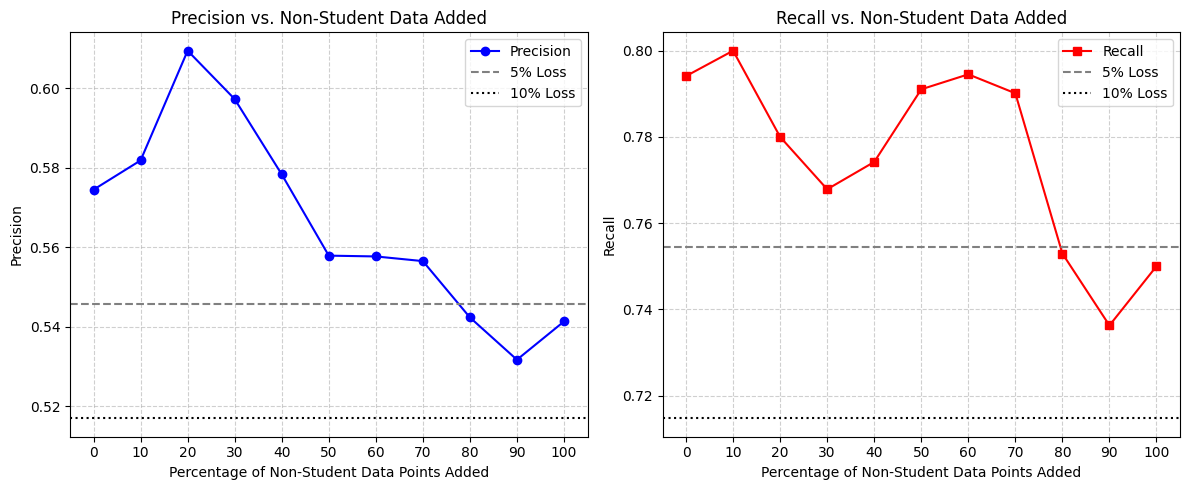

In [25]:
x_values = np.arange(0, 101, 10)
precisions = []
recalls = []
for i in range(11):
    # add i*10% from non-student data to student data
    non_student_data_points = df_holdout_non_students_balanced.sample(frac=0.1*i, random_state=1)
    df_holdout_mixed = pd.concat([df_holdout_students_balanced, non_student_data_points])
    _, _, non_student_precision, non_student_recall = evaluate_model(df_train_students_balanced, df_holdout_students, df_holdout_mixed)
    precisions.append(np.mean(non_student_precision))
    recalls.append(np.mean(non_student_recall))

precision_95 = 0.95 * precisions[0]
precision_90 = 0.90 * precisions[0]
recall_95 = 0.95 * recalls[0]
recall_90 = 0.90 * recalls[0]

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

axes[0].plot(x_values, precisions, marker='o', label='Precision', color='b')
axes[0].axhline(y=precision_95, color='gray', linestyle='--', label='5% Loss')
axes[0].axhline(y=precision_90, color='black', linestyle=':', label='10% Loss')
axes[0].set_xlabel('Percentage of Non-Student Data Points Added')
axes[0].set_ylabel('Precision')
axes[0].set_title('Precision vs. Non-Student Data Added')
axes[0].set_xticks(x_values)
axes[0].legend()
axes[0].grid(True, linestyle='--', alpha=0.6)

axes[1].plot(x_values, recalls, marker='s', label='Recall', color='r')
axes[1].axhline(y=recall_95, color='gray', linestyle='--', label='5% Loss')
axes[1].axhline(y=recall_90, color='black', linestyle=':', label='10% Loss')
axes[1].set_xlabel('Percentage of Non-Student Data Points Added')
axes[1].set_ylabel('Recall')
axes[1].set_title('Recall vs. Non-Student Data Added')
axes[1].set_xticks(x_values)
axes[1].legend()
axes[1].grid(True, linestyle='--', alpha=0.6)

plt.tight_layout()
plt.show()

---
## Question 2: Gradually adding non-students to train data

Now we do not add non-student data to the holdout set, but we gradually add it to the training. This way we want to find out, when we reached the precision and recall scores of the original model when using non-student data as the holdout set.

Before doing that we need to train a model on all the training data as a reference.
Therefor we use the RandomForestClassifier model here and train it on all train data. This way we can get a baseline that is comparable to the results of mini project 2. The predictions of the non-student holdout set on this trained model will then be our baseline for the comparison. Those baselines will be displayed in the plots as dashed lines.

Now we can gradually add non-student data to the training data and evaluate the model on the holdout set. We plot the results to see if there is a clear trend.

Here again, we can see an upward trend. Precision and recall increase, as we add more non-student data to the training set. Although this trend is very volatile, we can clearly see a tendency here. But we can see from these plots, that when adding 20% of the non-student data to the training set, we already reach similar precision and recall scores of the original model. This is interesting because we only have 20% of the non-student data in the training set, but we already reach the same performance as the original model. For the recall the story is a bit different. Only from 50% to 60% non-student data added, we reach a similar recall score as the original model.

This in return means that we need to add about a half of the non-student data to the training set to reach the same performance as the original model.

In [15]:
_, _, non_student_precision_baseline, non_student_recall_baseline = evaluate_model(pd.concat([df_train_students, df_train_non_students]), df_holdout_non_students, df_holdout_non_students)

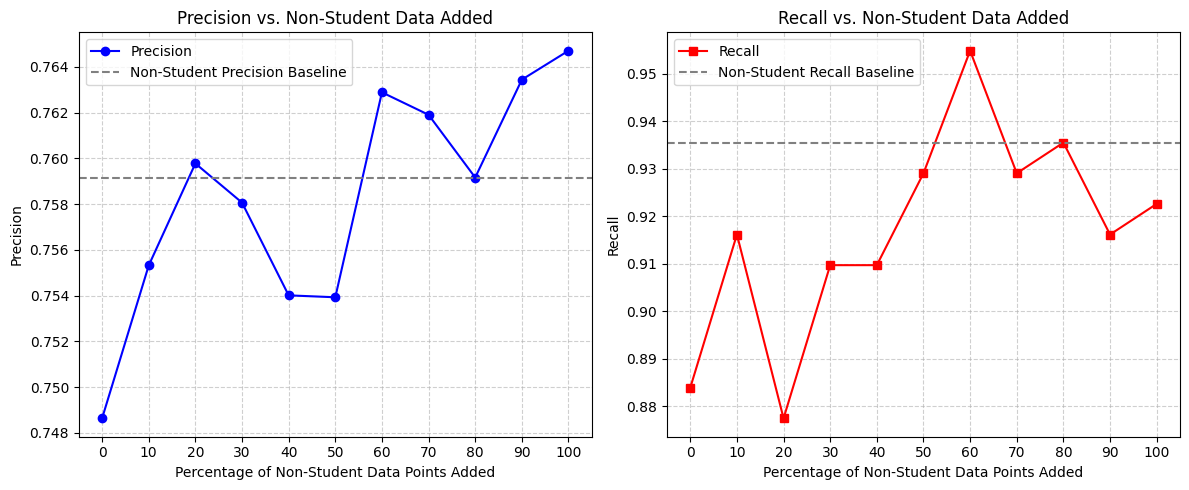

In [16]:
precisions = []
recalls = []
for i in range(11):
    # add i*10% from non-student data to student data
    non_student_data_points = df_train_non_students.sample(frac=0.1*i, random_state=42)
    df_train_mixed = pd.concat([df_train_students, non_student_data_points])
    _, _, non_student_precision, non_student_recall = evaluate_model(df_train_mixed, df_holdout_students, df_holdout_non_students)
    precisions.append(np.mean(non_student_precision))
    recalls.append(np.mean(non_student_recall))

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

axes[0].plot(x_values, precisions, marker='o', label='Precision', color='b')
axes[0].axhline(y=non_student_precision_baseline, color='gray', linestyle='--', label='Non-Student Precision Baseline')
axes[0].set_xlabel('Percentage of Non-Student Data Points Added')
axes[0].set_ylabel('Precision')
axes[0].set_title('Precision vs. Non-Student Data Added')
axes[0].set_xticks(x_values)
axes[0].legend()
axes[0].grid(True, linestyle='--', alpha=0.6)

axes[1].plot(x_values, recalls, marker='s', label='Recall', color='r')
axes[1].axhline(y=non_student_recall_baseline, color='gray', linestyle='--', label='Non-Student Recall Baseline')
axes[1].set_xlabel('Percentage of Non-Student Data Points Added')
axes[1].set_ylabel('Recall')
axes[1].set_title('Recall vs. Non-Student Data Added')
axes[1].set_xticks(x_values)
axes[1].legend()
axes[1].grid(True, linestyle='--', alpha=0.6)

plt.tight_layout()
plt.show()